## A: default mode

1) project residual stream values along the LDA direction 
 - does this imply a certain mode is the default? and one is the special 'mode'

## B: minimal steering 

1) starting from layer1, can we 
     - inject the steering vector, 
     - then evaluate future layers
     - then inject the correction needed to steer the model in the next direction 

 - overall, find the minimal injection needed to steer the output

2) try out a scaled version of injection 
 - determine layerwise scales needed to make the overall effect of adding in the scales * steering to the resid_pre is equal to the overall steering vector 

 - could go layer by layer

## C: generations from steering 

1) inject the steering vector, or a version which accomplishes the steering, and look at completions 

2) patch in the heads and look to see whether their effect is the same / similar as the steering vector injection


## D: augmented head search 

1) expand the initial search for vectors attending to think and stop think, to include those tokens immediately following them 
 - does this give us more heads?




In [1]:
from activation_patching_toolkit import *
from typing import Optional, List, Dict

/root/mech_interp_research/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)

device = utils.get_device()

reference_model_path = 'meta-llama/Llama-3.1-8B'
baseline_model_path = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

baseline_model_hf = AutoModelForCausalLM.from_pretrained(baseline_model_path, torch_dtype=torch.bfloat16)
baseline_model_tokenizer = AutoTokenizer.from_pretrained(baseline_model_path)

model = HookedTransformer.from_pretrained_no_processing(
    reference_model_path,
    hf_model=baseline_model_hf,
    tokenizer=baseline_model_tokenizer,
    device=device,
    move_to_device=True,
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.84it/s]


Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


In [7]:
weight_vectors = np.load('layer_analyses/combined_delta_vectors.npy')
steering_vectors = [None]+[-torch.tensor(w, device='cuda:0') for w in weight_vectors]

# B : minimal steering 

In [33]:

def compute_iterative_deltas_final_token_hooks(
    model: HookedTransformer,
    steering_vectors: List[Optional[torch.Tensor]],
    think_prompt: str
) -> List[Optional[torch.Tensor]]:
    """
    Returns `delta` of the same length as `steering_vectors` so that if you
    inject delta[L] at blocks.L.hook_resid_pre (only on the final token),
    you exactly recover steering_vectors[L] there.

    - Never uses run_with_cache (only run_with_hooks).
    - Hooks by the string "blocks.{L}.hook_resid_pre".
    - Captures/injects only the final token (i.e. [:, -1, :]).
    """
    device = next(model.parameters()).device
    max_layer = len(steering_vectors) - 1

    # 1) BASELINE: capture unperturbed final-token resid_pre for each L
    base_resid_pres: dict = {}
    base_forward_hooks: List[Tuple[str, Callable]] = []

    def capture_factory(L: int) -> Callable:
        def capture(resid_pre, **kwargs):
            # grab [batch=0, seq=-1, :]
            base_resid_pres[L] = resid_pre[0, -1].detach().clone()
            return resid_pre
        return capture

    # collect baseline capture hooks
    for L, sv in enumerate(steering_vectors):
        if sv is None:
            continue
        hook_name = f"blocks.{L}.hook_resid_pre"
        base_forward_hooks.append((hook_name, capture_factory(L)))

    # run baseline
    _ = model.run_with_hooks(
        think_prompt,
        fwd_hooks=base_forward_hooks
    )

    # move captures to base_resid
    base_resid = {L: v.to(device) for L, v in base_resid_pres.items()}

    # 2) ITERATIVELY compute delta[1..max_layer]
    delta: List[Optional[torch.Tensor]] = [None] * (max_layer + 1)

    def inject_factory(vec: torch.Tensor) -> Callable:
        def inject(resid_pre, **kwargs):
            out = resid_pre.clone()
            out[:, -1, :] += vec
            return out
        return inject

    for L in range(1, max_layer + 1):
        sv = steering_vectors[L]
        if sv is None:
            delta[L] = None
            continue

        hooks: List[Tuple[str, Callable]] = []

        # a) re-inject all previous deltas at their layers
        for j in range(1, L):
            dj = delta[j]
            if dj is None:
                continue
            v = dj.to(device)
            hook_name = f"blocks.{j}.hook_resid_pre"
            hooks.append((hook_name, inject_factory(v)))

        # b) capture at layer L
        curr_cap: dict = {}
        def capture(resid_pre, **kwargs):
            curr_cap['v'] = resid_pre[0, -1].detach().clone()
            return resid_pre
        hooks.append((f"blocks.{L}.hook_resid_pre", capture))

        # c) rerun think prompt with injections + capture
        _ = model.run_with_hooks(
            think_prompt,
            fwd_hooks=hooks
        )

        # d) measure shift and compute remainder
        curr = curr_cap['v'].to(device)
        measured = curr - base_resid[L]
        delta[L] = (sv.to(device) - measured).detach().clone()

    return delta


In [34]:
rc = ReasoningAnsweringComparator(
    model,
    "What is the fifth prime?",
    immediately_answer=True,
)

rc.think_prefix

'<｜begin▁of▁sentence｜><｜User｜>What is the fifth prime?<｜Assistant｜><think>\n'

In [35]:
deltas = compute_iterative_deltas_final_token_hooks(
    model,
    steering_vectors,
    think_prompt=rc.think_prefix,
)

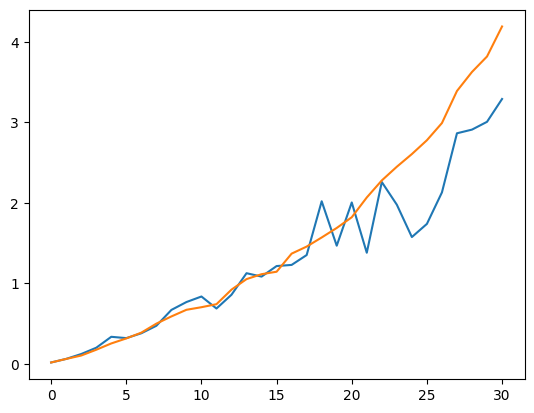

In [39]:

# plot the magnitude of the deltas
plt.plot([torch.norm(d).item() for d in deltas[1:]])
plt.plot([torch.norm(d).item() for d in steering_vectors[1:]])
plt.show()

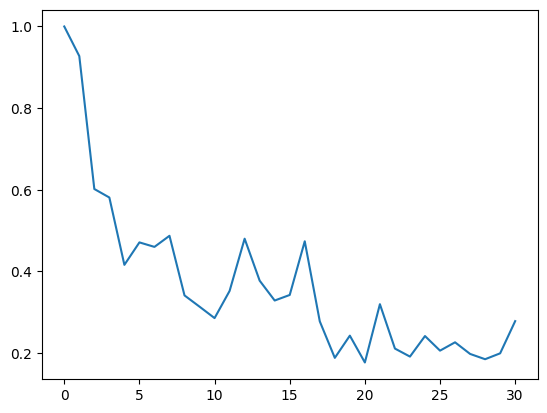

In [40]:
# compute the cosine similarity of the deltas
cos_sim = []
for i in range(1, len(deltas)):
    if deltas[i] is not None and steering_vectors[i] is not None:
        cos_sim.append(torch.nn.functional.cosine_similarity(deltas[i], steering_vectors[i], dim=0).item())
    else:
        cos_sim.append(None)
plt.plot(cos_sim)
plt.show()